In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geostatspy.GSLIB as GSLIB          # GSLIB utilities, viz and wrapped functions
import geostatspy.geostats as geostats    # GSLIB converted to Python
import seaborn as sns
import scipy                              # statistics
import scipy.linalg                       # linear algebra library
import math                               # trig, etc.
import random                             # bootstrap
from scipy import stats
from scipy.stats import ttest_ind as welch     # Welch's t-test for the mean
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
np.warnings.filterwarnings('ignore')

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

# Functions

In [2]:
def sgsim(df,xcol,ycol,vcol,wcol,scol,tmin,tmax,itrans,ismooth,dftrans,tcol,twtcol,zmin,zmax,ltail,ltpar,utail,utpar,nsim,
          nx,xmn,xsiz,ny,ymn,ysiz,seed,ndmin,ndmax,nodmax,mults,nmult,noct,radius,radius1,sang1,
          mxctx,mxcty,ktype,colocorr,sec_map,vario):
    
# Parameters from sgsim.inc    
    MAXNST=2; MAXROT=2; UNEST=-99.0; EPSLON=1.0e-20; VERSION=2.907
    KORDEI=12; MAXOP1=KORDEI+1; MAXINT=2**30
    
# Set other parameters
    np.random.seed(seed)
    nxy = nx*ny
    sstrat = 0 # search data and nodes by default, turned off if unconditional
    radsqd = radius * radius
    sanis1 = radius1/radius
    if ktype == 4: varred = 1.0
        
# load the variogram
    nst = int(vario['nst'])
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst,dtype=int)
    ang = np.zeros(nst); anis = np.zeros(nst)
    
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];        

# Set the constants
    MAXCTX = mxctx
    MAXCTY = mxcty
    MAXCXY = MAXCTX * MAXCTY
    MAXX   = nx
    MAXY   = ny
    MAXZ   = 1 # assuming 2D for now
    MXY  = MAXX * MAXY
    if MXY < 100: MXY = 100
    MAXNOD = nodmax
    MAXSAM = ndmax
    MAXKR1 = MAXNOD + MAXSAM + 1
#    print('MAXKR1'); print(MAXKR1)
    MAXKR2 = MAXKR1 * MAXKR1
    MAXSBX = 1
    if nx >  1:
        MAXSBX = int(nx/2)
        if MAXSBX > 50: MAXSBX=50
    MAXSBY = 1
    if ny > 1: 
        MAXSBY = int(ny/2)
        if MAXSBY > 50: MAXSBY=50

    MAXSBZ = 1
    MAXSB = MAXSBX*MAXSBY*MAXSBZ
    
# Declare arrays

    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax,dtype = int)
    
# Perform some quick checks
    if nx > MAXX or ny> MAXY:
        print('ERROR: available grid size: ' + str(MAXX) + ',' + str(MAXY) + ',' + str(MAXZ) +'.')
        print('       you have asked for : ' + str(nx) + ',' + str(ny) + ',' + str(nz) + '.')
        return sim
    if ltail != 1 and ltail != 2:
        print('ERROR invalid lower tail option ' + str(ltail))
        print('      only allow 1 or 2 - see GSLIB manual ')
        return sim
    if utail != 1 and utail != 2 and utail != 4:
        print('ERROR invalid upper tail option ' + str(ltail))
        print('      only allow 1,2 or 4 - see GSLIB manual ')
        return sim 
    if utail == 4 and utpar < 1.0:
        print('ERROR invalid power for hyperbolic tail' + str(utpar))
        print('      must be greater than 1.0!')
        return sim
    if ltail == 2 and ltpar < 0.0:
        print('ERROR invalid power for power model' + str(ltpar))
        print('      must be greater than 0.0!')
        return sim
    if utail == 2 and utpar < 0.0: 
        print('ERROR invalid power for power model' + str(utpar))
        print('      must be greater than 0.0!')
        return sim
     
# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax,nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    vr_orig = np.copy(vr)
#    print('size of data extract'); print(len(vr))
    wt = []; wt = np.array(wt)
    if wcol > -1: 
        wt = df_extract[wcol].values 
    else:
        wt = np.ones(nd)
    sec = []; sec = np.array(sec)
    if scol > -1:
        sec = df_extract[scol].values
    if itrans == 1:
        if ismooth == 1:
            dftrans_extract = dftrans.loc[(dftrans[tcol] >= tmin) & (dftrans[tcol] <= tmax)]  
            ntr = len(dftrans_extract)
            vrtr = dftrans_extrac[tcol].values
            if twtcol > -1: 
                vrgtr = dftrans_extrac[tcol].values
            else:
                vrgtr = np.ones(ntr) 
        else:
            vrtr = df_extract[vcol].values
            ntr = len(df_extract)  
            vrgtr = np.copy(wt)
        twt = np.sum(vrgtr)
# sort        
        vrtr,vrgtr = geostats.dsortem(0,ntr,vrtr,2,b=vrgtr)

# Compute the cumulative probabilities and write transformation table
        twt   = max(twt,EPSLON)
        oldcp = 0.0
        cp    = 0.0
#        print('ntr'); print(ntr)
        for j in range(0,ntr):               
            cp =  cp + vrgtr[j]/twt
            w  = (cp + oldcp)*0.5
            vrg = geostats.gauinv(w)
            oldcp =  cp
# Now, reset the weight to the normal scores value:
            vrgtr[j] = vrg
              
        twt = np.sum(wt)             
# Normal scores transform the data
        for id in range(0,nd):
            if itrans == 1: 
                vrr = vr[id]
                j = geostats.dlocate(vrtr,1,nd,vrr)
                j   = min(max(0,j),(nd-2))
                vrg = geostats.dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[nd-1]): vrg = vrgtr[nd-1]
                vr[id] = vrg   
    
    weighted_stats_orig = geostats.DescrStatsW(vr_orig,weights=wt)
    orig_av = weighted_stats_orig.mean        
    orig_ss = weighted_stats_orig.var   
    
    weighted_stats = geostats.DescrStatsW(vr,weights=wt)
    av = weighted_stats.mean        
    ss = weighted_stats.var        

#     print('\n Data for SGSIM: Number of acceptable data     = ' + str(nd))
#     print('                 Number trimmed                = ' + str(len(df)- nd))
#     print('                 Weighted Average              = ' + str(round(orig_av,4)))
#     print('                 Weighted Variance             = ' + str(round(orig_ss,4)))
#     print('                 Weighted Transformed Average  = ' + str(round(av,4)))
#     print('                 Weighted Transformed Variance = ' + str(round(ss,4)))
              
# Read in secondary data           
    sim = np.random.rand(nx*ny)
    index = 0
    for ixy in range(0,nxy):
        sim[index] = index
    
    lvm = []; lvm = np.array(lvm)
    if ktype >= 2:
        #lvm = np.copy(sec_map.flatten())
        ind = 0
        lvm = np.zeros(nxy)
        for iy in range(0,ny):
            for ix in range(0,nx):
                lvm[ind] = sec_map[ny-iy-1,ix]    
                ind = ind + 1
        if ktype == 2 and itrans == 1: 
            for ixy in range(0,nxy): 
# Do we to transform the secondary variable for a local mean?
                vrr = lvm[ixy]
                j = geostats.dlocate(vrtr,1,ntr,vrr)
                j   = min(max(0,j),(ntr-2))
                vrg = geostats.dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[ntr-1]): vrg = vrgtr[nd-1]
                lvm[ixy] = vrg 
        av = np.average(lvm)
        ss = np.var(lvm)
        print(' Secondary Data: Number of data             = ' + str(nx*ny))
        print('                 Equal Weighted Average     = ' + str(round(av,4)))
        print('                 Equal Weighted Variance    = ' + str(round(ss,4)))             

# Do we need to work with data residuals? (Locally Varying Mean)
        if ktype == 2:
            sec = np.zeros(nd)
            for idd in range(0,nd): 
                ix = geostats.getindex(nx,xmn,xsiz,x[idd])
                iy = geostats.getindex(ny,ymn,ysiz,y[idd])
                index = ix + (iy-1)*nx
                sec[idd] = lvm[index]
# Calculation of residual moved to krige subroutine: vr(i)=vr(i)-sec(i)


# Do we need to get an external drift attribute for the data?
        if ktype == 3:
            for idd in range(0,nd): 
                if sec[i] != UNEST:
                    ix = getindx(nx,xmn,xsiz,x[idd])
                    iy = getindx(ny,ymn,ysiz,y[idd])
                    ind = ix + (iy)*nx
                    sec[ind] = lvm[ind]

# Transform the secondary attribute to normal scores?
        if ktype == 4:
            order_sec = np.zeros(nxy)
            ind = 0
            for ixy in range(0,nxy): 
                order_sec[ixy] = ind  
                ind = ind + 1
            print(' Transforming Secondary Data with')
            print(' variance reduction of ' + str(varred))            
            lvm,order_sec = geostats.dsortem(0,nxy,lvm,2,b=order_sec)
            oldcp = 0.0
            cp    = 0.0
            for i in range(0,nxy): 
                cp =  cp + (1.0/(nxy))
                w  = (cp + oldcp)/2.0
                lvm[i] = geostats.gauinv(w)
                lvm[i] = lvm[i] * varred
                oldcp  =  cp
            order_sec,lvm = geostats.dsortem(0,nxy,order_sec,2,b=lvm) 
#            return np.reshape(lvm,(ny,nx)) # check the transform

# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search.
#     print('Setting up rotation matrices for variogram and search') 
    if nst == 1:
        rotmat = geostats.setrot(ang[0],ang[0],sang1,anis[0],anis[0],sanis1,nst,MAXROT=2)
    else:
        rotmat = geostats.setrot(ang[0],ang[1],sang1,anis[0],anis[1],sanis1,nst,MAXROT=2)
    isrot = 2 # search rotation is appended as 3rd

    rotmat_2d, maxcov = geostats.setup_rotmat2(c0,nst,it,cc,ang) # will use one in the future
#    print('MaxCov = ' + str(maxcov))
    
# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree  = geostats.sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
              
# Set up the covariance table and the spiral search:
    cov_table,tmp,order,ixnode,iynode,nlooku,nctx,ncty = geostats.ctable(MAXNOD,MAXCXY,MAXCTX,MAXCTY,MXY,
                                xsiz,ysiz,isrot,nx,ny,nst,c0,cc,aa,it,ang,anis,rotmat,radsqd)
       
#    print('Covariance Table'); print(cov_table)
# MAIN LOOP OVER ALL THE SIMULAUTIONS:
    for isim in range(0,nsim):
          
# Work out a random path for this realization:
        sim = np.random.rand(nx*ny)
        order = np.zeros(nxy)
        ind = 0
        for ixy in range(0,nxy): 
            order[ixy] = ind  
            ind = ind + 1
            
# The multiple grid search works with multiples of 4 (yes, that is
# somewhat arbitrary):

        if mults == 1:
            for imult in range(0,nmult): 
                nny = int(max(1,ny/((imult+1)*4)))
                nnx = int(max(1,nx/((imult+1)*4)))
#                print('multi grid - nnx, nny'); print(nnx,nny)
                jy  = 1
                jx  = 1
                for iy in range(0,nny): 
                    if nny > 0: jy = iy*(imult+1)*4
                    for ix in range(0,nnx):
                        if nnx > 0: jx = ix*(imult+1)*4
                        index = jx + (jy-1)*nx
                        sim[index] = sim[index] - (imult+1)

    
# Initialize the simulation:
        sim, order = geostats.dsortem(0,nxy,sim,2,b=order)
        sim.fill(UNEST)
#         print('Working on realization number ' + str(isim))

# Assign the data to the closest grid node:

        TINY = 0.0001
        for idd in range(0,nd):
#            print('data'); print(x[idd],y[idd])
            ix = geostats.getindex(nx,xmn,xsiz,x[idd])
            iy = geostats.getindex(ny,ymn,ysiz,y[idd])
            ind = ix + (iy-1)*nx 
            xx  = xmn + (ix)*xsiz
            yy  = ymn + (iy)*ysiz
#            print('xx, yy' + str(xx) + ',' + str(yy))
            test = abs(xx-x[idd]) + abs(yy-y[idd])

# Assign this data to the node (unless there is a closer data):
            if sstrat == 1:
                if sim[ind] > 0.0:
                    id2 = int(sim[ind]+0.5)
                    test2 = abs(xx-x(id2)) + abs(yy-y(id2))
                    if test <= test2: 
                        sim[ind] = idd
                    else:
                        sim[ind] = id2

# Assign a flag so that this node does not get simulated:
            if sstrat == 0 and test <= TINY: sim[ind]=10.0*UNEST

# Now, enter data values into the simulated grid:
        for ind in range(0,nxy):              
            idd = int(sim[ind]+0.5)
            if idd > 0: sim[ind] = vr[id]
        irepo = max(1,min((nxy/10),10000))          

# MAIN LOOP OVER ALL THE NODES:
        for ind in range(0,nxy):  
#             if (int(ind/irepo)*irepo) == ind:
#                 print('   currently on node ' + str(ind))
              
# Figure out the location of this point and make sure it has
# not been assigned a value already:

            index = int(order[ind]+0.5)
            if (sim[index] > (UNEST+EPSLON)) or (sim[index] < (UNEST*2.0)): continue
            iy   = int((index)/nx) 
            ix   = index - (iy)*nx
            xx = xmn + (ix)*xsiz
            yy = ymn + (iy)*ysiz   
            current_node = (yy,xx)
#            print('Current_node'); print(current_node)

# Now, we'll simulate the point ix,iy,iz.  First, get the close data
# and make sure that there are enough to actually simulate a value,
# we'll only keep the closest "ndmax" data, and look for previously
# simulated grid nodes:

            if sstrat == 0:
#                print('searching for nearest data')
                na = -1   # accounting for 0 as first index
                if ndmax == 1:
                    dist = np.zeros(1); nums = np.zeros(1)
                    dist[0], nums[0] = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
                else:
                    dist, nums = tree.query(current_node,ndmax)
                # remove any data outside search radius
                
#                print('nums'); print(nums)
#                print('dist'); print(dist)
                na = len(dist)
                nums = nums[dist<radius]
                dist = dist[dist<radius] 
                na = len(dist) 
                if na < ndmin: continue     # bail if not enough data
#                print('Found ' + str(na) + 'neighbouring data')            
                    
#            print('node search inputs')
#            print('nodmax ' + str(nodmax))
#            print('ixnode'); print(ixnode)
                    
            ncnode, icnode, cnodev, cnodex, cnodey = geostats.srchnd(ix,iy,nx,ny,xmn,ymn,xsiz,ysiz,sim,noct,nodmax,ixnode,iynode,nlooku,nctx,ncty,UNEST)
        
#           print('srchnd'); print(ncnode,icnode,cnodev,cnodex,cnodey)
#           print('Result of srchnd, cnodex = '); print(cnodex)
            nclose = na
 #           print('srch node, nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
 #           print('nums'); print(nums)
# Calculate the conditional mean and standard deviation.  This will be
# done with kriging if there are data, otherwise, the global mean and
# standard deviation will be used:

            if ktype == 2:
                gmean = lvm[index]
            else:
                gmean = 0.0

            if nclose+ncnode < 1:
                cmean  = gmean
                cstdev = 1.0

#Perform the kriging.  Note that if there are fewer than four data
# then simple kriging is prefered so that the variance of the
# realization does not become artificially inflated:

            else:
                lktype = ktype
                if ktype == 1 and (nclose+ncnode) < 4: lktype=0
                cmean, cstdev = geostats.krige(ix,iy,nx,ny,xx,yy,lktype,x,y,vr,sec,colocorr,lvm,nums,cov_table,nctx,ncty,icnode,ixnode,iynode,cnodev,cnodex,cnodey,
                                      nst,c0,9999.9,cc,aa,it,ang,anis,rotmat_2d,maxcov,MAXCTX,MAXCTY,MAXKR1,
                                      MAXKR2)

# Draw a random number and assign a value to this node:
            p = np.random.rand()
            xp = geostats.gauinv(p)
            sim[index] = xp * cstdev + cmean
#            print('simulated value = ' + str(sim[index]))

# Quick check for far out results:
            if abs(cmean) > 5.0 or abs(cstdev) > 5.0 or abs(sim[index]) > 6.0:
                print('WARNING: grid node location: ' + str(ix) + ',' + str(iy))
                print('         conditional mean and stdev:  ' + str(cmean) + ',' + str(cstdev))
                print('         simulated value:    ' + str(sim[index]))

# Do we need to reassign the data to the grid nodes?
        if sstrat == 0:
#             print('Reassigning data to nodes')
            for iid in range(0,nd): 
                ix = geostats.getindex(nx,xmn,xsiz,x[iid])
                iy = geostats.getindex(ny,ymn,ysiz,y[iid])
                xx  = xmn + (ix)*xsiz
                yy  = ymn + (iy)*ysiz
                ind = ix + (iy-1)*nx 
                test=abs(xx-x[iid])+abs(yy-y[iid])
                if test <= TINY: sim[ind] = vr[iid]

# Back transform each value and write results:
        ne = 0
        av = 0.0
        ss = 0.0
        for ind in range(0,nxy):
            iy = int((index-1)/nx) + 1
            ix = index - (iy-1)*nx
            simval = sim[ind]
            if simval > -9.0 and simval < 9.0:
                ne = ne + 1
                av = av + simval
                ss = ss + simval*simval
            if itrans == 1 and simval > (UNEST+EPSLON):
                simval = geostats.backtr_value(simval,vrtr,vrgtr,zmin,zmax,ltail,ltpar,utail,utpar)
                if simval < zmin: simval = zmin
                if simval > zmax: simval = zmax
            sim[ind] = simval
#            print('simulated value = ' + str(sim[ind]) + ' at location index = ' + str(ind))
        av = av / max(ne,1.0)
        ss =(ss / max(ne,1.0)) - av * av
#         print('\n Realization ' + str(isim) + ': number   = ' + str(ne))
#         print('                                   mean     = ' + str(round(av,4)) + ' (close to 0.0?)')
#         print('                                   variance = ' + str(round(ss,4)) + ' (close to gammabar(V,V)? approx. 1.0)')

# END MAIN LOOP OVER SIMULATIONS:
        sim_out = np.zeros((ny,nx))
        for ind in range(0,nxy):
            iy   = int((ind)/nx) 
            ix   = ind - (iy)*nx
            sim_out[ny-iy-1,ix] = sim[ind]
    return sim_out

def plotting(pad1, pad2, feature, bootstrap, same_pad, simulation, directory, case):
    """
    Function to compute the Gardner-Altman estimation plot
    All datapoints are presented as a swarmplot, which orders each point to display the underlying distribution.
    The effect size is presented as a bootstrap 95% confidence interval (95% CI) on a separate but aligned axes
    
    Parameters:
    pad1, pad2 : DataFrame; it has the property of interest
    feature: String; it is the name of the feature of interest
    bootstrap: DataFrame; it contains the spatial bootstrap realizations.
    same_pad: Boolean; True to specify the pads come from the same field, False otherwise
    case: 1 for scenario 1, 2 for scenario 2, 3 for scenario 3
    """
    ################################################
    # Previous computations
    ################################################
    conver = pd.DataFrame(pad1[feature].to_numpy(), columns=['Pad 1'])
    conver['Pad 2'] = pad2[feature].to_numpy()
    conver = conver.melt(var_name='Well Pad', value_name=feature)
    pad1_mean = pad1[feature].mean(); pad2_mean = pad2[feature].mean()
    effect_size = pad2_mean - pad1_mean

    # Compute the percentiles for the 95% CI
    per_up = bootstrap['Difference Means'].quantile(q=0.975); per_do = bootstrap['Difference Means'].quantile(q=0.025)
    # Compute the mean of the distribution of differences
    mean = bootstrap['Difference Means'].mean()
    # Minimum and maximum values of porosity
    por_min = np.floor(conver[feature].min()); por_max = np.ceil(conver[feature].max())
    # Minimum and maximum values of distribution of differences
    df_min = np.floor(bootstrap['Difference Means'].min()); df_max = np.ceil(bootstrap['Difference Means'].max())
    # left and right axes must be equal. Here we check whether they have the same length; if not, we update it
    len_bootstrap = len(np.arange(df_min, df_max)); len_property = len(np.arange(por_min, por_max))
    extra_inc = len_property - len_bootstrap # to check what axis is larger: left or right?

    if df_min > 0:
        df_min = 0

    ################################################
    # Plotting
    ################################################
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1.2, 1.2]})
    fig.subplots_adjust(left=0.02, bottom=0.1, right=0.95, top=0.99, wspace=0.25)

    ################################################
    # First axis: swarm plots
    ################################################
    sns.swarmplot(x='Well Pad', y=feature, data=conver, size=8, linewidth=2, ax=ax2)
    ax2.set_ylabel(feature, fontsize=14)
    ax2.set_xlabel('', fontsize=14)
    ax2.tick_params(axis='y')

    # Hide the right and top spines
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')

    ################################################
    # Second Axis: Spatial boootstrap
    ################################################
    sns.distplot(bootstrap['Difference Means'], kde=True, color='blue', vertical=True, ax=ax3).set(xlim=-1)

    ax3.set_ylabel('Mean difference', fontsize=14)
    ax3.set_xlabel('Pad 2 - Pad 1', fontsize=12)
    ax3.yaxis.set_label_position("right")
    ax3.plot([0, 0],[per_up, per_do],  'red', linewidth=4)
    ax3.plot(0, mean, 'o', markerfacecolor='black',markeredgecolor='black',
             markeredgewidth=1.0, markersize=10.0)

    ax3.plot(0, effect_size, '*', markerfacecolor='yellow',markeredgecolor='black',
             markeredgewidth=2.0, markersize=15.0, label='Effect size')
    ax3.axis([-1, 1, df_min, df_max])
    ax3.legend(loc=2)

    # Turn off tick labels
    ax3.set_xticklabels([])
    # Hide the left and top spines
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    # Only show ticks on the right and bottom spines
    ax3.yaxis.set_ticks_position('right')
    ax3.xaxis.set_ticks_position('bottom')

    # Legend box code from Joe Kington
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

    # Shrink current axis's height by 10% on the bottom
    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
              fancybox=True, shadow=True, ncol=5)

    ################################################
    # Horizontal lines for estimation effects
    ################################################
    if same_pad:
        # mean of well pad 1 is horizontally aligned with effect size = 0 (the line is straight)
        boolean1 = (pad1_mean > pad2_mean) and (0 > mean)
        # mean of well pad 2 is horizontally aligned with mean of the boostrap distribution (the line is straight)
        boolean2 = (pad1_mean < pad2_mean) and (0 < mean)
        if boolean1 or boolean2: # if either boolean1 or boolean2 is true, we can draw the estimation lines
            # Mean difference = 0. Draw an arrow between the same point in data coordinates,
            # but in different axes.
            xyA = (1, 0) # corresponding to ax3
            xyB = (0, pad1_mean) # corresponding to ax2
            con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                                  axesA=ax3, axesB=ax2, color="black", lw=1)
            ax3.add_artist(con)

            xyA = (1, mean) # corresponding to ax3
            xyB = (1, pad2_mean) # corresponding to ax2
            con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                                  axesA=ax3, axesB=ax2, color="black")
            ax3.add_artist(con)

            ##################################################################
            # Update the length of the axis to have straight estimation lines
            ##################################################################
            # If you have enter this loop, it means the lines are straight
            ## Both ax2 and ax3 axes must have the same percentage for the two lines
            if extra_inc > 0: # the axis length of the property is larger than the length of the bootstrap axis
                # Find the percentage that well pad 1 mean represents within the axis
                percent_ax2 = (pad1_mean - por_min)/len_property
                # Find the percentage that well pad 2 mean represents within the axis
                percent_ax3 = (pad2_mean - por_min)/len_property
                lag = - mean / (percent_ax2 - percent_ax3) # number of lags
                minimo = - percent_ax2 * lag # the smallest number of the second axis

                ax2.set_ylim(por_min, por_max)
                ax3.set_ylim(minimo, minimo + lag)

            elif extra_inc < 0: # length of the bootstrap axis is larger than the axis length of the property
                # Find the percentage that bootstrap mean represents within the axis
                percent_ax2 = (0 - df_min)/len_bootstrap
                # Find the percentage that 0 represents within the axis
                percent_ax3 = (mean - df_min)/len_bootstrap
                lag = (pad1_mean - pad2_mean) / (percent_ax2 - percent_ax3) # number of lags
                minimo = pad1_mean - percent_ax2 * lag # the smallest number of the second axis

                ax2.set_ylim(minimo, minimo + lag)

            else: # the axis have the same length
                ax2.set_ylim(por_min, por_max)
                ax3.set_ylim(df_min, df_max)

        else: # the lines will be crooked. Do not draw estimation lines
            ax2.set_ylim(por_min, por_max)
            ax3.set_ylim(df_min, np.ceil(max(df_max, effect_size)))

    ##################################################
    # The pads do not come from field
    ##################################################
    else: # the lines will be crooked. Do not draw estimation lines
        ax2.set_ylim(por_min, por_max)
        ax3.set_ylim(np.floor(min(df_min, effect_size)), np.ceil(max(df_max, effect_size)))

    ##################################################
    # Add legends
    ##################################################
    ax2.plot(0, pad1_mean, 's', markerfacecolor='yellow',markeredgecolor='black',
             markeredgewidth=2.0, markersize=10.0, label='Pad 1 mean')
    ax2.plot(1, pad2_mean, 's', markerfacecolor='yellow',markeredgecolor='black',
             markeredgewidth=2.0, markersize=10.0, label='Pad 2 mean')

    # Shrink current axis's height by 10% on the bottom
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
              fancybox=True, shadow=True, ncol=5)
    
    
    ########################################################################
    # Contour plot
    ########################################################################
    xx, yy = np.meshgrid(np.arange(xmin, xmax, cell_size), np.arange(ymax, ymin, -1 * cell_size))
    vmin = np.floor(np.min(simulation))
    vmax = np.ceil(np.max(simulation))
    df = pad
    xcol = 'X'; ycol = 'Y'; vcol = 'Porosity'; titles='Porosity realization and well pads'
    xlabel='X(m)'; ylabel='Y(m)'; vlabel='Porosity (%)'
    
    im1 = ax1.contourf(
        xx,
        yy,
        simulation,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        levels=np.linspace(vmin, vmax, 100),
    )
    
    cb = fig.colorbar(im1, orientation="horizontal", ax=ax1, label='Porosity %', pad=0.1, fraction = 0.05)
#     im1.set_clim(vmin, vmax)
    lista = list(np.linspace(vmin, vmax, 5))
    cb.set_ticks(lista)
    cb.set_ticklabels(lista)
    
    ax1.scatter(
        df[xcol],
        df[ycol],
        s=None,
        c=df[vcol],
        marker=None,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
        linewidths=0.8,
        verts=None,
        edgecolors="black",
    )
    
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)

    ########################################################################
    # pads
    ########################################################################
    nxwell = 5; nywell = 2 # number of wells in x and y
    xspace = 50; yspace = 50 # space in x and y between wells
    # Pad 1
    ox1 = 20; oy1 = 51 # origin of pad times (x10m) (bottom left corner)
    # Pad 2
    ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
    # Pad 3
    ox3 = 65; oy3 = 2 # origin of pad times (x10m) (bottom left corner)
    # Pad 4
    ox4 = 65; oy4 = 70 # origin of pad (bottom left corner)
    
    ########################################################################
    # Three scenarios are possible
    ########################################################################

    if case == 1:
        ax1.add_patch(Rectangle((ox1*10*1.03, oy1*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                                  linewidth = 1.0,alpha=0.2,facecolor = None))
        ax1.add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell*1.1, height=yspace*nywell2*1.1, color='black',
                                  linewidth = 1.0,alpha=0.2,facecolor = None))

    elif case == 2:       
        
        pad_tempo_1 = extract_pad_sample(simulation, xmin, xmax, ymin, ymax, cell_size, ox=ox1, oy=oy1, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
        pad_tempo_2 = extract_pad_sample(simulation, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
        
        padnew = pd.concat([pad_tempo_1,pad_tempo_2],axis=0)
        ax1.plot(padnew['X'], padnew['Y'], 'wo', alpha=0.5)

        ax1.add_patch(Rectangle((ox1*10*1.03, oy1*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='white',
                                      linewidth = 1.0,alpha=0.2,facecolor = None)) # correct    
        ax1.add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='white',
                                      linewidth = 1.0,alpha=0.2,facecolor = None))  # correct
        ax1.add_patch(Rectangle((ox3*10*1.03, oy3*10*1.9), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                                      linewidth = 1.0,alpha=0.2,facecolor = None)) # correct
        ax1.add_patch(Rectangle((ox4*10*1.03, oy4*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                                      linewidth = 1.0,alpha=0.2,facecolor = None)) # correct
        
        pad_tempo_1 = extract_pad_sample(simulation, xmin, xmax, ymin, ymax, cell_size, ox=ox3, oy=oy3, xspace=xspace, 
                                         yspace=yspace, nxwell=nxwell, nywell=nywell, name='Porosity')
        pad_tempo_2 = extract_pad_sample(simulation, xmin, xmax, ymin, ymax, cell_size, ox=ox4, oy=oy4, xspace=xspace,
                                         yspace=yspace, nxwell=nxwell, nywell=nywell, name='Porosity')
        
        padnew = pd.concat([pad_tempo_1,pad_tempo_2],axis=0)
#         ax1.plot(padnew['X'], padnew['Y'], alpha=0.5) # plot the input pads
        ax1.scatter(
                padnew[xcol],
                padnew[ycol],
                s=None,
                c=padnew[vcol],
                marker=None,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                alpha=0.8,
                linewidths=0.8,
                verts=None,
                edgecolors="black",
            )
        
    elif case == 3:
        ########################################################################
        # Extra wells outside the pads
        ########################################################################
        wells = [925, 275, 585, 275, 175, 585, 525, 585, 915, 355, 195, 485, 765, 355, 345, 675, 505, 405]
        ax1.add_patch(Rectangle((ox1*10*1.03, oy1*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                                  linewidth = 1.0,alpha=0.2,facecolor = None))
        ax1.add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                                  linewidth = 1.0,alpha=0.2,facecolor = None))
        
        for i in np.arange(0, int(len(wells)), 2):
            ax1.plot(wells[i], wells[i+1], 'y*', markersize=10)

    else:
        print('Please enter a valid option')

    fig.savefig(directory, dpi=600, format="tiff", bbox_inches='tight')
    
    plt.show()

In [3]:
def est_plot(pad1, pad2, feature, bootstrap, same_pad):
    """
    Function to compute the Gardner-Altman estimation plot
    All datapoints are presented as a swarmplot, which orders each point to display the underlying distribution.
    The effect size is presented as a bootstrap 95% confidence interval (95% CI) on a separate but aligned axes
    
    Parameters:
    pad1, pad2 : DataFrame; it has the property of interest
    feature: String; it is the name of the feature of interest
    bootstrap: DataFrame; it contains the spatial bootstrap realizations.
    same_pad: Boolean; True to specify the pads come from the same field, False otherwise
    """
    ################################################
    # Previous computations
    ################################################
    conver = pd.DataFrame(pad1[feature].to_numpy(), columns=['Pad 1'])
    conver['Pad 2'] = pad2[feature].to_numpy()
    conver = conver.melt(var_name='Well Pad', value_name=feature)
    pad1_mean = pad1[feature].mean(); pad2_mean = pad2[feature].mean()
    effect_size = pad2_mean - pad1_mean

    # Compute the percentiles for the 95% CI
    per_up = bootstrap['Difference Means'].quantile(q=0.975); per_do = bootstrap['Difference Means'].quantile(q=0.025)
    # Compute the mean of the distribution of differences
    mean = bootstrap['Difference Means'].mean()
    # Minimum and maximum values of porosity
    por_min = np.floor(conver[feature].min()); por_max = np.ceil(conver[feature].max())
    # Minimum and maximum values of distribution of differences
    df_min = np.floor(bootstrap['Difference Means'].min()); df_max = np.ceil(bootstrap['Difference Means'].max())
    # left and right axes must be equal. Here we check whether they have the same length; if not, we update it
    len_bootstrap = len(np.arange(df_min, df_max)); len_property = len(np.arange(por_min, por_max))
    extra_inc = len_property - len_bootstrap # to check what axis is larger: left or right?

    if df_min > 0:
        df_min = 0

    ################################################
    # Plotting
    ################################################
    fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(6, 7))

    ################################################
    # First axis: swarm plots
    ################################################
    sns.swarmplot(x='Well Pad', y=feature, data=conver, size=8, linewidth=2, ax=ax1)
    ax1.set_ylabel(feature, fontsize=14)
    ax1.set_xlabel('', fontsize=14)
    ax1.tick_params(axis='y')

    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    ################################################
    # Second Axis: Spatial boootstrap
    ################################################
    sns.distplot(bootstrap['Difference Means'], kde=True, color='blue', vertical=True, ax=ax2).set(xlim=-1)

    ax2.set_ylabel('Mean difference', fontsize=14)
    ax2.set_xlabel('Pad 2 - Pad 1', fontsize=12)
    ax2.yaxis.set_label_position("right")
    ax2.plot([0, 0],[per_up, per_do],  'red', linewidth=4)
    ax2.plot(0, mean, 'o', markerfacecolor='black',markeredgecolor='black',
             markeredgewidth=1.0, markersize=10.0)

    ax2.plot(0, effect_size, '*', markerfacecolor='yellow',markeredgecolor='black',
             markeredgewidth=2.0, markersize=15.0, label='Effect size')
    ax2.axis([-1, 1, df_min, df_max])
    ax2.legend(loc=2)

    # Turn off tick labels
    ax2.set_xticklabels([])
    # Hide the left and top spines
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # Only show ticks on the right and bottom spines
    ax2.yaxis.set_ticks_position('right')
    ax2.xaxis.set_ticks_position('bottom')

    # Legend box code from Joe Kington
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

    # Shrink current axis's height by 10% on the bottom
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
              fancybox=True, shadow=True, ncol=5)

    ################################################
    # Horizontal lines for estimation effects
    ################################################
    if same_pad:
        # mean of well pad 1 is horizontally aligned with effect size = 0 (the line is straight)
        boolean1 = (pad1_mean > pad2_mean) and (0 > mean)
        # mean of well pad 2 is horizontally aligned with mean of the boostrap distribution (the line is straight)
        boolean2 = (pad1_mean < pad2_mean) and (0 < mean)
        if boolean1 or boolean2: # if either boolean1 or boolean2 is true, we can draw the estimation lines
            # Mean difference = 0. Draw an arrow between the same point in data coordinates,
            # but in different axes.
            xyA = (1, 0) # corresponding to ax2
            xyB = (0, pad1_mean) # corresponding to ax1
            con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                                  axesA=ax2, axesB=ax1, color="black", lw=1)
            ax2.add_artist(con)

            xyA = (1, mean) # corresponding to ax2
            xyB = (1, pad2_mean) # corresponding to ax1
            con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                                  axesA=ax2, axesB=ax1, color="black")
            ax2.add_artist(con)

            ##################################################################
            # Update the length of the axis to have straight estimation lines
            ##################################################################
            # If you have enter this loop, it means the lines are straight
            ## Both ax1 and ax2 axes must have the same percentage for the two lines
            if extra_inc > 0: # the axis length of the property is larger than the length of the bootstrap axis
                # Find the percentage that well pad 1 mean represents within the axis
                percent_ax1 = (pad1_mean - por_min)/len_property
                # Find the percentage that well pad 2 mean represents within the axis
                percent_ax2 = (pad2_mean - por_min)/len_property
                lag = - mean / (percent_ax1 - percent_ax2) # number of lags
                minimo = - percent_ax1 * lag # the smallest number of the second axis

                ax1.set_ylim(por_min, por_max)
                ax2.set_ylim(minimo, minimo + lag)

            elif extra_inc < 0: # length of the bootstrap axis is larger than the axis length of the property
                # Find the percentage that bootstrap mean represents within the axis
                percent_ax1 = (0 - df_min)/len_bootstrap
                # Find the percentage that 0 represents within the axis
                percent_ax2 = (mean - df_min)/len_bootstrap
                lag = (pad1_mean - pad2_mean) / (percent_ax1 - percent_ax2) # number of lags
                minimo = pad1_mean - percent_ax1 * lag # the smallest number of the second axis

                ax1.set_ylim(minimo, minimo + lag)

            else: # the axis have the same length
                ax1.set_ylim(por_min, por_max)
                ax2.set_ylim(df_min, df_max)

        else: # the lines will be crooked. Do not draw estimation lines
            ax1.set_ylim(por_min, por_max)
            ax2.set_ylim(df_min, np.ceil(max(df_max, effect_size)))

    ##################################################
    # The pads do not come from field
    ##################################################
    else: # the lines will be crooked. Do not draw estimation lines
        ax1.set_ylim(por_min, por_max)
        ax2.set_ylim(np.floor(min(df_min, effect_size)), np.ceil(max(df_max, effect_size)))

    ##################################################
    # Add legends
    ##################################################
    
    ax1.plot(0, pad1_mean, 's', markerfacecolor='yellow',markeredgecolor='black',
             markeredgewidth=2.0, markersize=10.0, label='Pad 1 mean')
    ax1.plot(1, pad2_mean, 's', markerfacecolor='yellow',markeredgecolor='black',
             markeredgewidth=2.0, markersize=10.0, label='Pad 2 mean')

    # Shrink current axis's height by 10% on the bottom
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
              fancybox=True, shadow=True, ncol=5)

    plt.show()

Let's define a function to sample data from a well. [Pyrcz](https://github.com/GeostatsGuy/RepeatableResearch/blob/master/Gussow_Model_Resample_Pyrcz.ipynb) offers a great example:

In [4]:
# extract pad samples from a model   
def extract_pad_sample(array,xmin,xmax,ymin,ymax,step,ox,oy,xspace,yspace,nxwell,nywell,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    ixspace = int(xspace / step)
    iyspace = int(yspace / step)
    iiy = 0
    for iy in range(0,iyspace*nywell+1):
        if iiy >= iyspace:
            iix = 0
            for ix in range(0,ixspace*nxwell+1):
                if iix >= ixspace:
                    cx = ox + ix; cy = oy + iy 
                    x.append(step*(float(cx)-0.5)); y.append(step*(float(cy)-0.5)); v.append(array[ny-cy+1,cx])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

To impose a geological trend, we will use a [bivariate normal distribution](http://mathworld.wolfram.com/BivariateNormalDistribution.html) window. Modified from [Wendi Liu's](https://github.com/whenn0406) original work

In [5]:
def multi_gaussian(rho, mean1, mean2, std1, std2, x1,x2):
    """
    rho: correlation coefficient. Between -1 and 1
    mean1: mean of variable 1. Use it to center the Gaussian window
    mean2: mean of variable 2. Use it to center the Gaussian window
    std1: standard deviation of variable 1. Spread of the window
    std2: standard deviation of variable 2. Spread of the window
    x1: variable 1
    x2: variable 2
    """
    z = ((x1-mean1)**2)/std1**2 - (2*rho*(x1-mean1)*(x2-mean2))/(std1 * std2) + ((x2-mean2)**2)/std2**2
    prob = np.exp(-z/(2*(1-rho**2)))/(2* np.pi * np.sqrt(1 - rho))/(std1 * std2)
    return prob

Let's define a folder where we will store the archives.

# Case I: Stationarity
## 1.1 Case: completely stationary Gaussian (using well pads)

We will now create (simulate) porosity data to populate an array of shape 100x100. First, we need to establish the modeling parameters.

In [6]:
path = 'C:\\Users\\jjs4476\\Documents\\Papers\\Geostatistical significance\\Notebook\\Results'

In [7]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 11                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 45                   # Porosity variogram ranges and azimuth
mean = 15.0; stdev = 1.5                                         # Porosity mean and standard deviation
cmap = plt.cm.inferno                                            # using the plasma color map

Then, we have to define the spatial continuity of our model; i.e., define the variogram. Next, we proceed with the simulation. If you did not see it before, the simulation uses a range (90) that is less than 1/10 of the extent of the model (1000 m).

After the simulattion we use `GSLIB.affine` to change and move the shape of the distribution with the values of mean and standard deviation we want.

In [8]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

Finally we plot the simulation and the two well pads. Recall that the simulation is our true model. The array **sim** is our truth model.

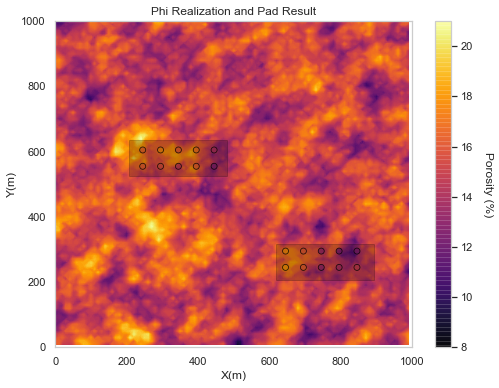

In [9]:
# This is the example realization with pads for the above Figure
# Pad 1
ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(sim, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(sim, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad = pd.concat([pad1,pad2],axis=0)

plt.figure(figsize=(8, 6))
GSLIB.locpix_st(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)), pad,
                'X','Y','Porosity','Phi Realization and Pad Result', 'X(m)', 'Y(m)','Porosity (%)',cmap)
plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.show()

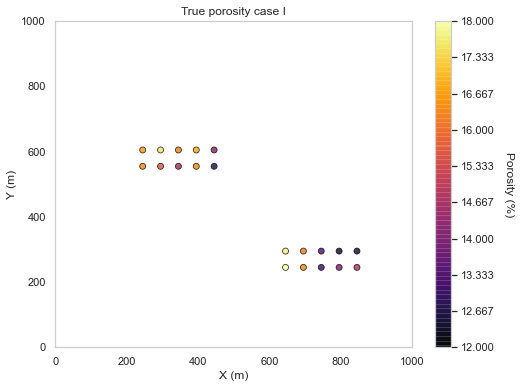

In [29]:
GSLIB.locmap(
    df=pad,
    xcol='X',
    ycol='Y',
    vcol='Porosity',
    xmin=0,
    xmax=1000,
    ymin=0,
    ymax=1000,
    vmin=12,
    vmax=18,
    title='True porosity case I',
    xlabel='X (m)',
    ylabel='Y (m)',
    vlabel='Porosity (%)',
    cmap=cmap,
    fig_name='lala',
)

In [32]:
plt.contourf?

Let's assign the well number to the index of each `DataFrame` containing the information for each well pad. The well index is obtained the Fortran-style order using `ravel()`.

In [10]:
index1 = []; index2 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(sim.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(sim.ravel() == pad2.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2

Now let's perform the spatial bootstrap using [Journel's](https://link.springer.com/article/10.1007%2FBF00714200) approach. Perform *enough* realization using the previous parameters, changing only the seed number.
1. Sample at the well pad locations for each realization from 1
2. Compute the mean for each well pad from 2
3. Repeat 1 and 2
4. After computing all the realizations, substract the mean 1 from mean 2

In [11]:
num_sim = 20 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values])
    mean2 = np.mean(sim.ravel()[pad2.index.values])
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2

############################################################
## Final computations
############################################################
summary['Difference Means'] = summary['N2 Mean'] - summary['N1 Mean'] # compute difference of the means

Save the summary that contains the spatial bootstrap in a pickle archive.

In [12]:
# summary.to_pickle("./case12.pkl")
summary = pd.read_pickle(path + "./case12.pkl")

In [13]:
summary.iloc[:9999, :]['Difference Means'].quantile(q=0.975) - summary.iloc[:9999, :]['Difference Means'].quantile(q=0.025)

3.418264558991642

In [14]:
summary = summary.iloc[:9999, :] # take only the first 9999 realization
summary['Difference Means'] = summary['N2 Mean'] - summary['N1 Mean']

Compute the [Gardner-Altman plot](https://en.wikipedia.org/wiki/Estimation_statistics#Gardner-Altman_plot) for some porosity values from the well pads (recall, it is a pre-drill assessment so they are not real data).

An estimation plot has [two key features](https://www.estimationstats.com/#/background)
1. All datapoints are presented as a swarmplot, which orders each point to display the underlying distribution.

2. The effect size is presented as a spatial bootstrap 95% confidence interval (95% CI) on a separate but aligned axes, where the effect size is displayed to the right of the raw data, and the mean of the test group is aligned with the effect size.

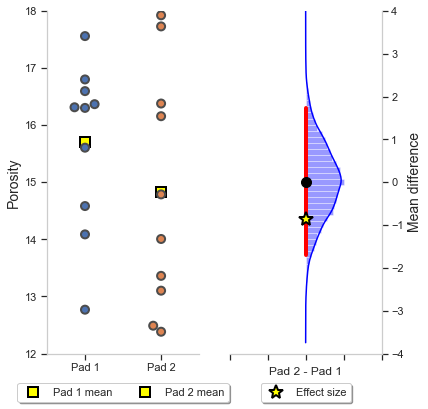

In [16]:
est_plot(pad1, pad2, 'Porosity', summary, same_pad=True)

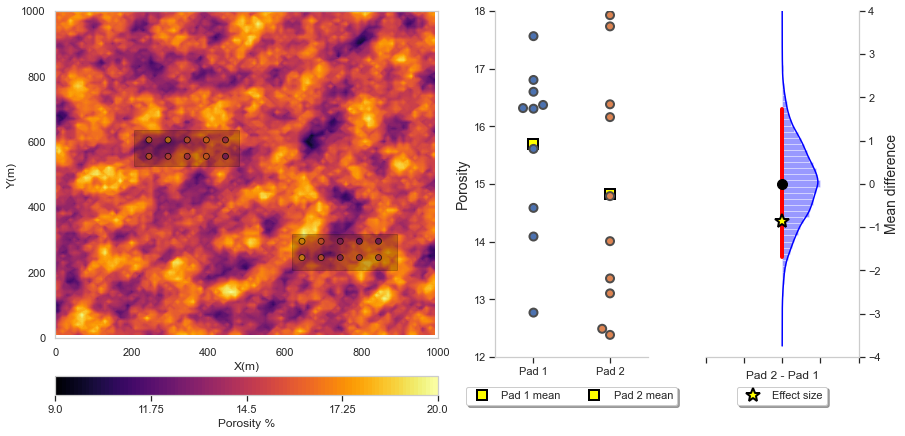

In [18]:
folder = 'Practical Workflow for Assessing Significance of Differences for Nonstationary Phenomenon'
directory = 'C:\\Users\\jjs4476\\Documents\\Papers\\Geostatistical significance/Fig3.tiff'

plotting(pad1, pad2, 'Porosity', summary, same_pad=True, simulation=sim, directory=directory, case=1)

The mean difference between Pad 1 and Pad 2 is shown in the above Gardner-Altman estimation plot. Both groups are plotted on the left axes; the mean difference is plotted on a floating axes on the right as a spatial bootstrap sampling distribution. The mean difference is depicted as a dot; the 95% confidence interval is indicated by the ends of the vertical error bar.
Credit to [estimationestats.com](https://www.estimationstats.com/#/analyze/two-independent-groups).

Let's compute the critical statistics for some $\alpha$ levels

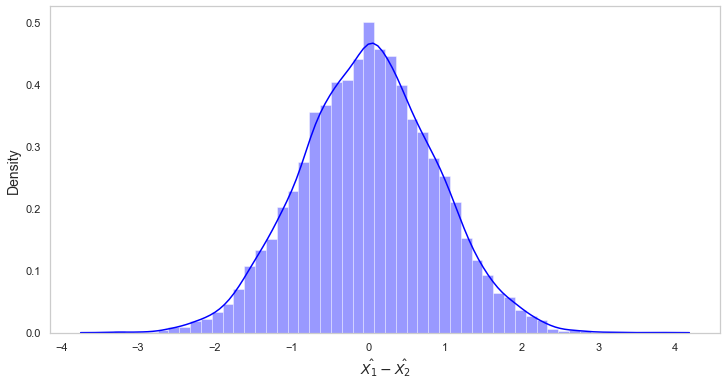

In [18]:
plt.figure(figsize=(12, 6))
sns.distplot(summary['Difference Means'], kde=True, color='blue')
plt.xlabel('$\hat{X_1} - \hat{X_2}$', fontsize=14)
plt.ylabel('Density', fontsize=14);

In [19]:
############################################################
## Critical values (empirical)
############################################################
per_up_10 = summary['Difference Means'].quantile(q=0.95); per_down_10 = summary['Difference Means'].quantile(q=0.05)
per_up_05 = summary['Difference Means'].quantile(q=0.975); per_down_05 = summary['Difference Means'].quantile(q=0.025)
per_up_01 = summary['Difference Means'].quantile(q=0.995); per_down_01 = summary['Difference Means'].quantile(q=0.005)

print('{0:5^s}'.format('CONFIDENCE INTERVALS'))
print('The 90% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_10, per_up_10))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))
print('The 99% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_01, per_up_01))

CONFIDENCE INTERVALS
The 90% CI: -1.44 < μ1-μ2 < 1.45
The 95% CI: -1.69 < μ1-μ2 < 1.73
The 99% CI: -2.24 < μ1-μ2 < 2.21


We pretend to observe a difference and we will compute
1. the empirical p-value
2. the Bayes factor bound
3. The likelihood of the alternative hypothesis being true

In [49]:
############################################################
## Insert observed difference
############################################################
observed_diff = -0.87 # pad1['Porosity'].mean() - pad2['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(summary['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=summary['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(summary['Difference Means'], other_diff)
denominator = length + 1

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(summary['Difference Means'] > observed_diff)
    smaller_than_left = sum(summary['Difference Means'] < other_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(summary['Difference Means'] > other_diff)
    smaller_than_left = sum(summary['Difference Means'] < observed_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: -0.87
Empirical p-value: 31.04%
Bayes factor bound: 1.01
There is at maximum a 50.32% chance the alternative hypothesis is true


Impressing, using the naive approach of the p-values, we would have concluded that a difference in porosity means equal to 1.71 is statistically significant. But simply it implies odds in favor of the alternative hypothesis relative to the null hypothesis of at most 2.46 to 1. Not a big deal. Moreover, it also means that there is 29% chance of the null hypothesis being true.

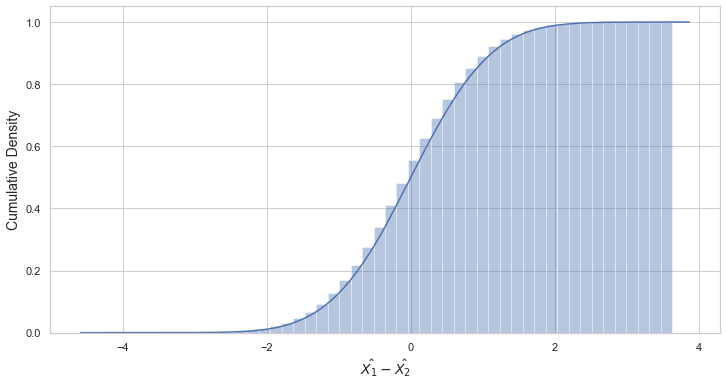

In [19]:
plt.figure(figsize=(12, 6))
plt.grid(b=None, which='major')
sns.distplot(summary['Difference Means'],kde_kws={'cumulative':True}, hist_kws={'cumulative':True})
plt.xlabel('$\hat{X_1} - \hat{X_2}$', fontsize=14)
plt.ylabel('Cumulative Density', fontsize=14);

# Embodiment II: non stationarity

Now, let's focus in a field with non stationary data, i.e. with a geological trend. The process involves three steps:

1. Create a stationary model
2. Create a trend model using a bivariate normal distribution
3. Add 1 and 2 to obtain the combined model

First, let's create again a stationary model.

In [7]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 43                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 45                    # Porosity variogram ranges and azimuth
mean = 15.0; stdev = 1.5                                         # Porosity mean and standard deviation
cmap = plt.cm.inferno                                            # using the plasma color map

Generate the first simulation and plot it. Recall that it does not have a  trend.

In [8]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

<Figure size 720x576 with 0 Axes>

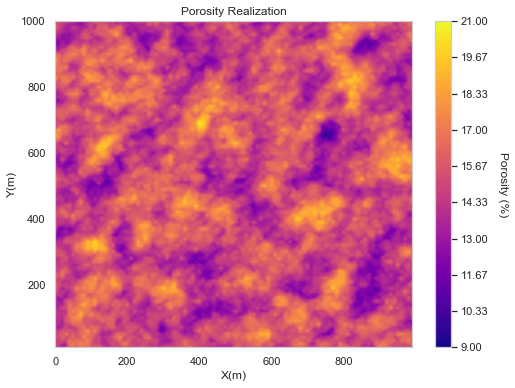

In [9]:
plt.figure(figsize=(10, 8));
cmap = plt.cm.plasma
GSLIB.pixelplt(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_Simulation');

### Trend

To impose a trend, use a multivariable function. Then add the known function (trend) to the previous simulation.

<Figure size 720x576 with 0 Axes>

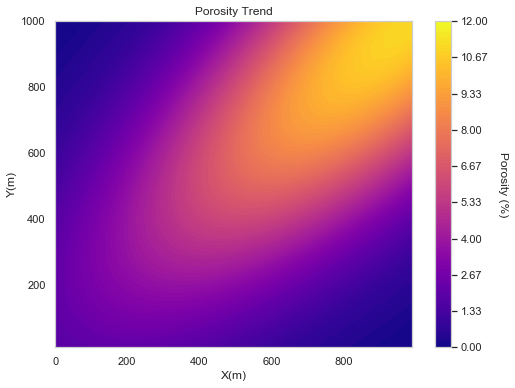

In [10]:
x = np.linspace(2,6, 100)
xx, yy = np.meshgrid(x, x) # create a meshgrid to simplify the addition of coordinate 
trend =  150 * np.flipud(multi_gaussian(rho=.8, mean1=6, mean2=6, std1=2.2, std2=2.2, x1=xx, x2=yy))

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.plasma
GSLIB.pixelplt(trend, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(trend)), np.ceil(np.max(trend)),
               "Porosity Trend", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_trend');

In [11]:
trend_mean = np.mean(trend)

Plot the combined model: trend + model

<Figure size 720x576 with 0 Axes>

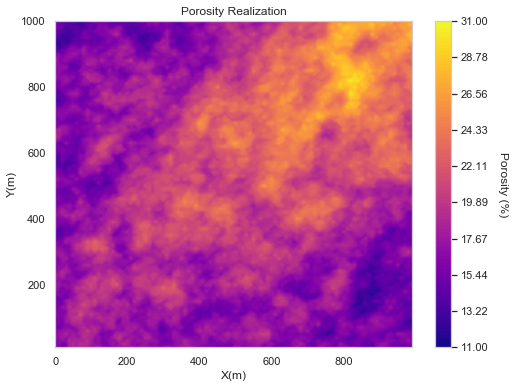

In [12]:
combined_model = trend + sim

plt.figure(figsize=(10, 8));
GSLIB.pixelplt(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)), np.ceil(np.max(combined_model)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_comb');

### First check

To check whether the matrices are correctly added, the combined model in one cell A should be equal to the sum of both the trend and the stationary models in the same cell A. Let's see.

In [21]:
combined_model[0, -1] == sim[0,-1] + trend[0, -1]

True

### Second check

To confirm the presence of a trend in our combined model, let's plot the variogram in the direction of major continuity: 0. To do so, we use `geostats.gam` because we have data points at each grid node. The coordinates `ixd, iyd` should be the following:

* Azimuth = 00; `ixd=0`, `iyd=1`
* Azimuth = 45; `ixd=1`, `iyd=1`
* Azimuth = 90; `ixd=1`, `iyd=0`

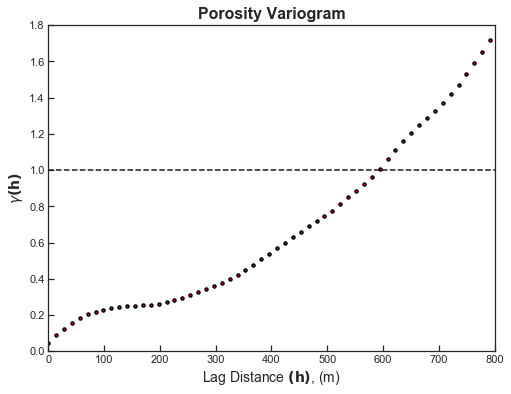

In [388]:
lag_phi, vario_phi, npar_phi = geostats.gam(combined_model,tmin = \
                            -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = -1, nlag = 80, isill = 1.0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lag_phi,vario_phi,'o', markerfacecolor='red',markeredgecolor='black',markersize=3.0,markeredgewidth=1.5)
ax.plot([0,2000],[1.0,1.0], 'k--')
ax.set_xlabel(r'Lag Distance $\bf(h)$, (m)', fontsize=14)
ax.set_ylabel(r'$\gamma \bf(h)$', fontsize=14)
ax.set_title('Porosity Variogram', fontsize=16, fontweight='bold')
ax.set_xlim([0,800])
ax.set_ylim([0,1.8])

folder = 'Practical Workflow for Assessing Significance of Differences for Nonstationary Phenomenon'
directory = 'C:\\Users\\jjs4476\\Documents\\Papers\\' + folder + '/Fig4.tiff'
fig.savefig(directory, dpi=600, format="tiff", bbox_inches='tight')

plt.show()

Bingo! the histogram shows a trend in 45 azimuth.

For a final check, we will transform our combined model into a `DataFrame` preserving the coordinates to obtain

1. the variogram map and
2. number of pairs plot.

In [100]:
x = np.arange(0, 999, 10) # The field has 100 cells in both X and Y and extends from 0 to 990 meters
xx, yy = np.meshgrid(x, x) # create a meshgrid to simplify the addition of coordinate 

# X coordinates format
xcoor = list(x)
xcoor = np.array(xcoor * 100)

# Y coordinates format
ycoor = []
for i in np.arange(len(x)):
    ycoor += list(yy[i, :])
ycoor = np.array(ycoor)
    
# DataFrame
trend_model = pd.DataFrame(np.ndarray.flatten(combined_model), columns=['Porosity'])
trend_model['X'] = xcoor
trend_model['Y'] = ycoor

In [101]:
trend_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
Porosity    10000 non-null float64
X           10000 non-null int32
Y           10000 non-null int32
dtypes: float64(1), int32(2)
memory usage: 156.3 KB


Let's plot the variogram map and the number of pairs.

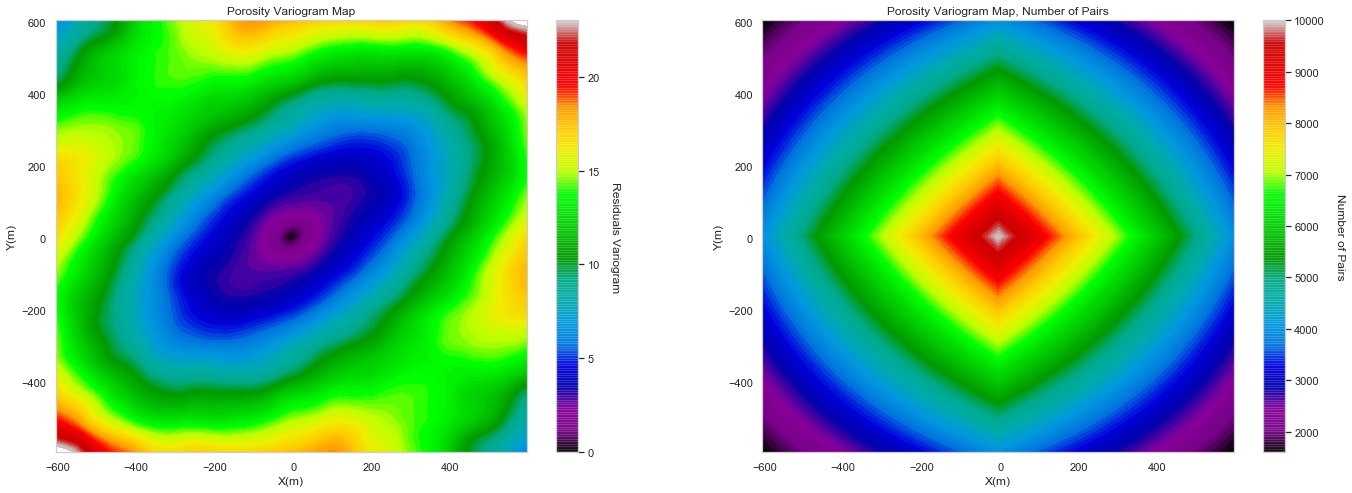

In [516]:
## Lag distance approximation
nlag = 60 # how many lags (or data points) do you want? # 50

lag_dist = 10 # update your lag distance #8000
xy_minmax = int(nlag * lag_dist + lag_dist/2)

cmap = plt.cm.nipy_spectral
# Plots
# vmap, npmap = geostats.varmapv(trend_model,'X','Y','Porosity',tmin=-999,tmax=999, nxlag=nlag, nylag=nlag,
#                                dxlag=lag_dist, dylag=lag_dist, minnp=1, isill=1)

plt.subplot(121)
GSLIB.pixelplt_st(np.flipud(vmap),-xy_minmax,xy_minmax,-xy_minmax,xy_minmax, lag_dist,0,23,
                  'Porosity Variogram Map','X(m)','Y(m)','Residuals Variogram',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(npmap,-xy_minmax,xy_minmax,-xy_minmax,xy_minmax, lag_dist,1600, 10000,
                  'Porosity Variogram Map, Number of Pairs',
                  'X(m)','Y(m)','Number of Pairs',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

## Case 2.1 Trend and well pad locations as case 1.2

We will sample from our combined model (the one that a trend) using two well pads, each one with 10 wells spaced 50 meters.

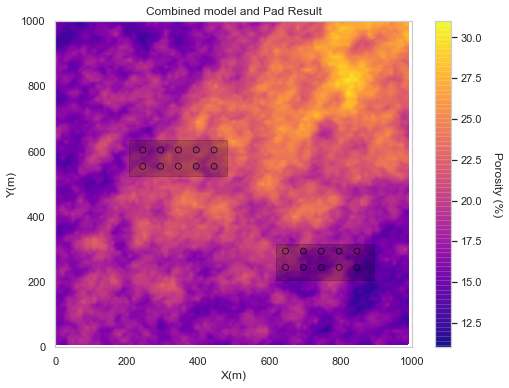

In [26]:
# This is the example realization with pads for the above Figure
# Pad 1
ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad = pd.concat([pad1,pad2],axis=0)

fig = plt.figure(figsize=(8, 6))
cmap = plt.cm.plasma

GSLIB.locpix_st(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)), np.ceil(np.max(combined_model)), pad,
                'X','Y','Porosity','Combined model and Pad Result', 'X(m)', 'Y(m)','Porosity (%)',cmap)
plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))

# folder = 'Practical Workflow for Assessing Significance of Differences for Nonstationary Phenomenon'
# directory = 'C:\\Users\\jjs4476\\Documents\\Papers\\' + folder + '/Fig2.tiff'
# fig.savefig(directory, dpi=700, format="tiff", bbox_inches='tight')

# plt.show()

Store the well pads information (porosity and coordinates) in individual `DataFrames`.

We will store the values from the combined model!

In [27]:
index1 = []; index2 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(combined_model.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(combined_model.ravel() == pad2.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2

Let's store the porosity values from the trend model. We will add them back to the unconditional simulation, which is stationary, to simulate we sampled from the combined model.

In [28]:
pad1['Trend'] = trend.ravel()[pad1.index.values]
pad2['Trend'] = trend.ravel()[pad2.index.values]

Perfom the spatial bootstrap. However, there is a catch! Because a sequential Gaussian simulation provide stationary models, we will add the trend at the well locations only. This is an assumption of the paper: **the trend is known**

In [246]:
tic()

num_sim = 9999 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i') # unconditional simulation
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values] + pad1['Trend'])# add the porosity values from the trend back at data locations
    mean2 = np.mean(sim.ravel()[pad2.index.values] + pad2['Trend'])# add the porosity values from the trend back at data locations
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2

############################################################
## Final computations
############################################################
summary['Difference Means'] = summary['N2 Mean'] - summary['N1 Mean'] # compute difference of the means

toc()

Elapsed time: 0 days 0 hours 29 minutes 57 seconds.


Store the realizations in a pickle archive.

In [29]:
# summary.to_pickle(path + "./case21.pkl")
summary = pd.read_pickle(path + "./case21.pkl")

In [30]:
# summary['Difference Means'].quantile(q=0.975) - summary['Difference Means'].quantile(q=0.025)
summary['Difference Means'] = summary['N2 Mean'] - summary['N1 Mean']

Let's check the summary statistics.

In [31]:
(summary['Difference Means'].quantile(q=0.975) - summary['Difference Means'].quantile(q=0.025)) 

3.4270703005114553

In [32]:
summary.describe()

,N1 Mean,N2 Mean,Difference Means
count,9999.000000,9999.000000,9999.000000
mean,20.292411,17.531995,-2.760415
std,0.610743,0.604080,0.872151
min,18.112197,15.367779,-6.104784
25%,19.880843,17.121576,-3.352281
50%,20.295120,17.536673,-2.754182
75%,20.698394,17.940296,-2.168091
max,22.748353,19.640778,0.919973


Let's visualize the Gardner-Altman estimation plot

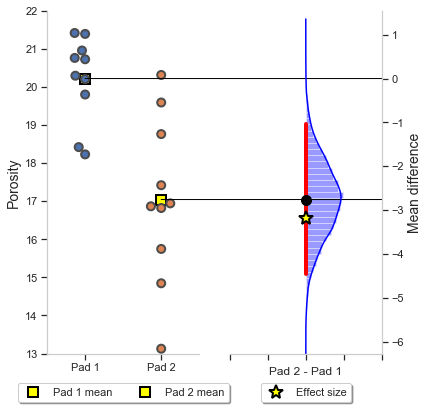

In [203]:
est_plot(pad1, pad2, 'Porosity', summary, same_pad=True)

Because of the stationarity assumption, the null hypothesis does not even lie within the CI of the resampling distribution. The spatial boostrap assesing the uncertainty in the difference of means is below (the same as the Gardner-Altman estimation plot)

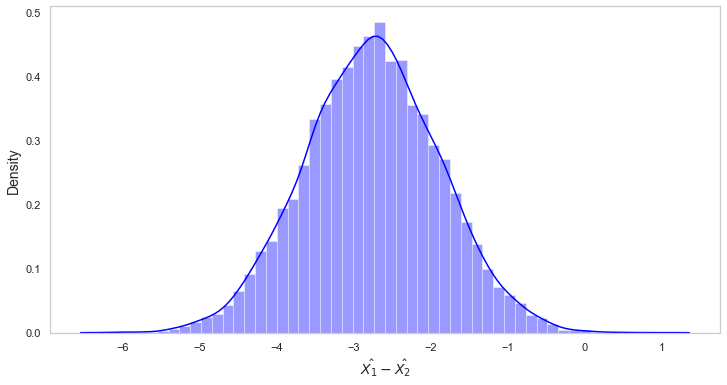

In [62]:
plt.figure(figsize=(12, 6))
sns.distplot(summary['Difference Means'], kde=True, color='blue')
plt.xlabel('$\hat{X_1} - \hat{X_2}$', fontsize=14)
plt.ylabel('Density', fontsize=14);

Now, let's check the critical values at some standard thresholds:

In [205]:
############################################################
## Critical values (empirical)
############################################################
per_up_10 = summary['Difference Means'].quantile(q=0.950); per_down_10 = summary['Difference Means'].quantile(q=0.050)
per_up_05 = summary['Difference Means'].quantile(q=0.975); per_down_05 = summary['Difference Means'].quantile(q=0.025)
per_up_01 = summary['Difference Means'].quantile(q=0.995); per_down_01 = summary['Difference Means'].quantile(q=0.005)

print('{0:5^s}'.format('CONFIDENCE INTERVALS'))
print('The 90% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_10, per_up_10))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))
print('The 99% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_01, per_up_01))

CONFIDENCE INTERVALS
The 90% CI: -4.20 < μ1-μ2 < -1.33
The 95% CI: -4.46 < μ1-μ2 < -1.03
The 99% CI: -5.01 < μ1-μ2 < -0.55


The final evaluation is next:

In [207]:
############################################################
## Insert observed difference
############################################################
observed_diff = pad2['Porosity'].mean() - pad1['Porosity'].mean() # pad1['Porosity'].mean() - pad2['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(summary['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=summary['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(summary['Difference Means'], other_diff)

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(summary['Difference Means'] > observed_diff)
    smaller_than_left = sum(summary['Difference Means'] < other_diff)
    denominator = length + 1
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(summary['Difference Means'] > other_diff)
    smaller_than_left = sum(summary['Difference Means'] < observed_diff)
    denominator = length + 1
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: -3.18
Empirical p-value: 63.21%
Bayes factor bound: 1.27
There is at maximum a 55.92% chance the alternative hypothesis is true


We computed the porosity means from the well pads that we used for the estimation plot. The Bayes factor bound is not promising and our data is not compatible is not the hypothesis most compatible with the data (p-value).

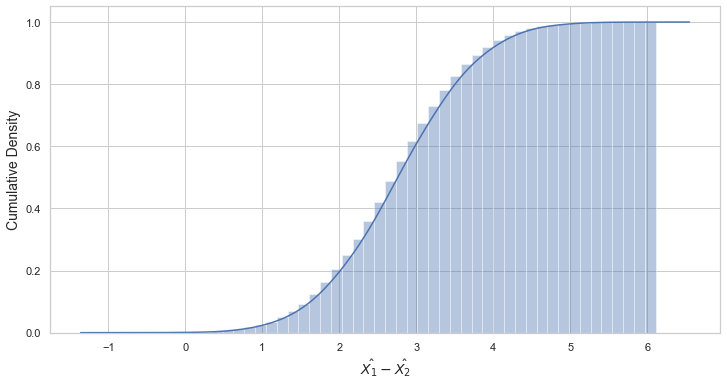

In [250]:
plt.figure(figsize=(12, 6))
plt.grid(b=None, which='major')
sns.distplot(summary['Difference Means'],kde_kws={'cumulative':True}, hist_kws={'cumulative':True})
plt.xlabel('$\hat{X_1} - \hat{X_2}$', fontsize=14)
plt.ylabel('Cumulative Density', fontsize=14);

## Case 2.2 Trend and pad 1 in trend, pad 2 not in trend

We will change the location of well pads so
* well pad 1 is located in a region with large porosity
* well pad 2 is in an area with small porosity

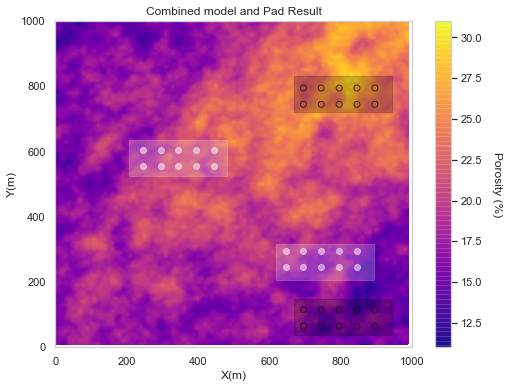

In [138]:
# This is the example realization with pads for the above Figure
# Pad 1
ox = 65; oy = 70 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 65; oy2 = 2 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad = pd.concat([pad1,pad2],axis=0)

plt.figure(figsize=(8, 6))
cmap = plt.cm.plasma

GSLIB.locpix_st(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)), np.ceil(np.max(combined_model)), pad,
                'X','Y','Porosity','Combined model and Pad Result', 'X(m)', 'Y(m)','Porosity (%)',cmap)
plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.9), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))

# Add the code below just to represent other well pads in white. DO NOT FORGET TO recompute the original well pads

# This is the example realization with pads for the above Figure
# Pad 1
ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad = pd.concat([pad1,pad2],axis=0)

plt.plot(pad['X'], pad['Y'], 'wo', alpha=0.5)
plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='white',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='white',
                              linewidth = 1.0,alpha=0.2,facecolor = None))

plt.show()

Again, store the values in `DataFrames` for the well pads.

In [139]:
index1 = []; index2 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(combined_model.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(combined_model.ravel() == pad2.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2

pad1['Trend'] = trend.ravel()[pad1.index.values]
pad2['Trend'] = trend.ravel()[pad2.index.values]

Perform spatial bootstrap and add the trend at the well locations.

In [140]:
tic()

num_sim = 9 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values] + pad1['Trend'])# add the porosity values from the trend back at data locations
    mean2 = np.mean(sim.ravel()[pad2.index.values] + pad2['Trend'])# add the porosity values from the trend back at data locations
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2

############################################################
## Final computations
############################################################

summary['Difference Means'] = summary['N1 Mean'] - summary['N2 Mean'] # compute difference of the means

toc()

Elapsed time: 0 days 0 hours 0 minutes 2 seconds.


Store the resampling in a pickle archive.

In [141]:
# summary.to_pickle(path + "./case22.pkl")
summary = pd.read_pickle(path + "./case22.pkl")

Compute the summary statistics.

In [142]:
summary['Difference Means'] = summary['N2 Mean'] - summary['N1 Mean']

In [143]:
summary.describe()

,N1 Mean,N2 Mean,Difference Means
count,9999.000000,9999.000000,9999.000000
mean,24.786913,15.717972,-9.068940
std,0.615468,0.618373,0.879770
min,22.609323,13.307196,-12.420048
25%,24.379646,15.300974,-9.663042
50%,24.780988,15.716724,-9.082264
75%,25.203408,16.133385,-8.483156
max,27.056896,17.915166,-5.875114


Let's visualize the estimation plot

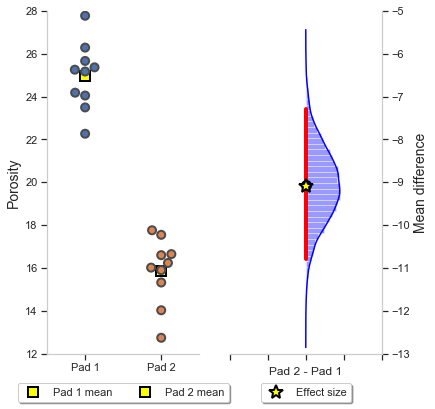

In [63]:
est_plot(pad1, pad2, 'Porosity', summary, same_pad=False)

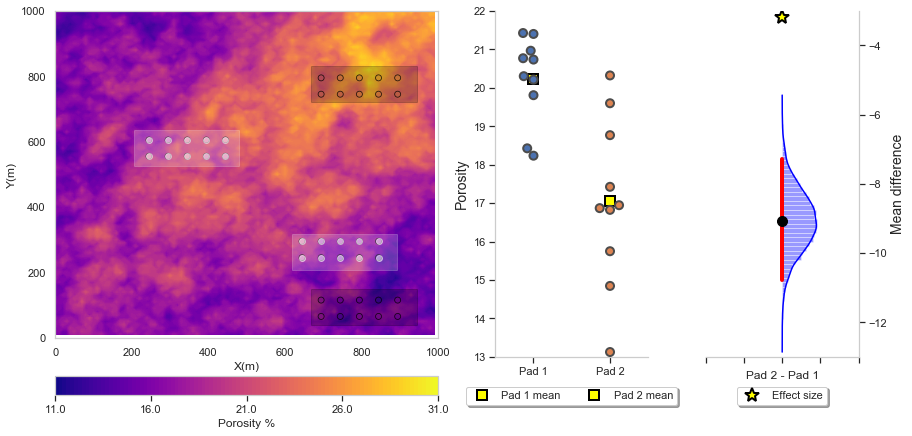

In [144]:
folder = 'Practical Workflow for Assessing Significance of Differences for Nonstationary Phenomenon'
directory = 'C:\\Users\\jjs4476\\Documents\\Papers\\' + folder + '/Fig5.tiff'

plotting(pad1, pad2, 'Porosity', summary, same_pad=False, simulation=combined_model,
        directory=directory, case=2)

Because of the trend the mean difference between the well pads does not include zero. The difference of means distribution is:

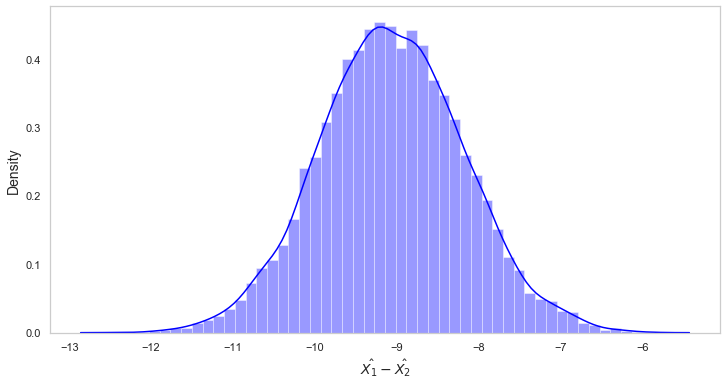

In [96]:
plt.figure(figsize=(12, 6))
sns.distplot(summary['Difference Means'], kde=True, color='blue')
plt.xlabel('$\hat{X_1} - \hat{X_2}$', fontsize=14)
plt.ylabel('Density', fontsize=14);

The critical values for the above distribution at the typical thresholds.

In [229]:
############################################################
## Critical values (empirical)
############################################################
per_up_10 = summary['Difference Means'].quantile(q=0.950); per_down_10 = summary['Difference Means'].quantile(q=0.050)
per_up_05 = summary['Difference Means'].quantile(q=0.975); per_down_05 = summary['Difference Means'].quantile(q=0.025)
per_up_01 = summary['Difference Means'].quantile(q=0.995); per_down_01 = summary['Difference Means'].quantile(q=0.005)

print('{0:5^s}'.format('CONFIDENCE INTERVALS'))
print('The 90% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_10, per_up_10))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))
print('The 99% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_01, per_up_01))

CONFIDENCE INTERVALS
The 90% CI: -10.52 < μ1-μ2 < -7.62
The 95% CI: -10.79 < μ1-μ2 < -7.29
The 99% CI: -11.35 < μ1-μ2 < -6.77


In [230]:
############################################################
## Insert observed difference
############################################################
observed_diff = pad2['Porosity'].mean() - pad1['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(summary['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=summary['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(summary['Difference Means'], other_diff)
denominator = length + 1

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(summary['Difference Means'] > observed_diff)
    smaller_than_left = sum(summary['Difference Means'] < other_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(summary['Difference Means'] > other_diff)
    smaller_than_left = sum(summary['Difference Means'] < observed_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: -3.18
Empirical p-value: 0.02%
Bayes factor bound: 215.96
There is at maximum a 99.54% chance the alternative hypothesis is true


We have taken the observed mean difference of porosity to an extreme of 12.50%. If that were the case, the Bayes factor bound gratly favors the alternative hypothesis with respect to the null hypothesis. Moreover, the null hypothesis probability to be true is 0.46% if the prior probabilities of both null and alternative hypotheses were equal.

# 3 Embodiment III: Nonstationary, correlation, conditioning data

## Case 3.1: well pads are located in locations as in case 2.1

We will add some wells outside the pads. These wells will have porosity data, which will impart spatial conditioning to the well pads.

First, create the true model (stationary)

<Figure size 720x576 with 0 Axes>

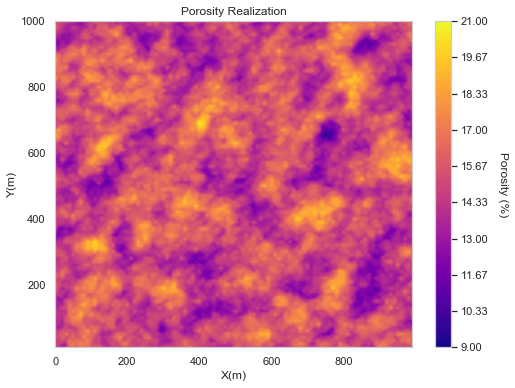

In [125]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.
# sim += trend

plt.figure(figsize=(10, 8));
cmap = plt.cm.plasma
GSLIB.pixelplt(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_Simulation');

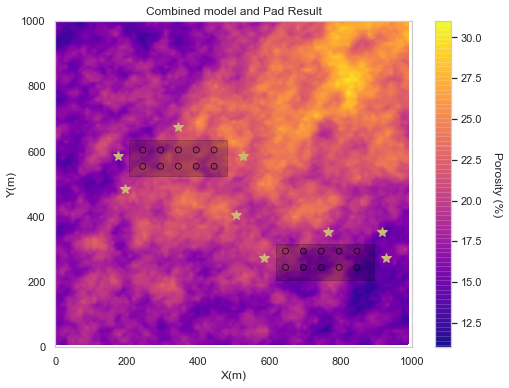

In [126]:
# add the trend and stationary to have a non stationary model. This is your true model
combined_model = sim + trend

########################################################################
# Well pads
########################################################################
# Pad 1
ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad = pd.concat([pad1,pad2],axis=0)

########################################################################
# Extra wells outside the pads
########################################################################
wells = [925, 275, 585, 275, 175, 585, 525, 585, 915, 355, 195, 485, 765, 355, 345, 675, 505, 405]

# Transform the previous list into a DataFrame
wells_df = pd.DataFrame(np.zeros((int(len(wells)/2), 3)), columns=['X', 'Y', 'Porosity'])
for i in np.arange(0, int(len(wells)), 2):
    wells_df.iloc[int(i/2), 0] = wells[i]
    wells_df.iloc[int(i/2), 1] = wells[i+1]

for i in range(len(wells_df)):
    wells_df.iloc[i, 2] = combined_model[int(100-np.floor(wells_df.iloc[i, 1])/10), int(np.ceil(wells_df.iloc[i, 0]/10))]
    
########################################################################
# Update the indexes in the data frames
########################################################################
index1 = []; index2 = []; index3 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(combined_model.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(combined_model.ravel() == pad2.iloc[phi,2])[0][0])
for phi in np.arange(0, len(wells_df)):
    index3.append(np.where(combined_model.ravel() == wells_df.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2
wells_df.index = index3
    
########################################################################
# Plotting
########################################################################
plt.figure(figsize=(8, 6))
cmap = plt.cm.plasma

GSLIB.locpix_st(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)),
                np.ceil(np.max(combined_model)), pad,'X','Y','Porosity','Combined model and Pad Result', 'X(m)',
                'Y(m)','Porosity (%)',cmap)
plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
for i in np.arange(0, int(len(wells)), 2):
    plt.plot(wells[i], wells[i+1], 'y*', markersize=10)

plt.show()

The conditional method requires the data in normal scores. Convert the porosity values from the existing wells (yellow stars) to normal scores.

In [127]:
wells_df['Porosity Ns'], tv, tns = geostats.nscore(df=wells_df, vcol='Porosity')

Add the trend porosity to the well pads.

In [128]:
pad1['Trend'] = trend.ravel()[pad1.index.values]
pad2['Trend'] = trend.ravel()[pad2.index.values]

It is a good idea to visualize the `DataFrame` of our wells and well pads to check for blunders. First, the existing wells. 

In [129]:
wells_df

,X,Y,Porosity,Porosity Ns
7293,925.0,275.0,15.594731,-0.589456
7259,585.0,275.0,20.225449,0.589456
4118,175.0,585.0,15.214340,-0.967422
4153,525.0,585.0,22.772147,1.593219
6492,915.0,355.0,14.441803,-1.735032
5120,195.0,485.0,19.542474,0.000000
6477,765.0,355.0,18.012134,-0.282216
3235,345.0,675.0,19.940667,0.282216
5951,505.0,405.0,20.569039,0.967422


Perform spatial bootstrap. In this case, we add the trend values at the well locations in each realization to account for non stationarities. Moreover, this is a conditional simulation, i.e. the porosity from the nine wells will be kept constant through all the iterations.

In [22]:
tic()

num_sim = 9 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim(nreal=1, df=wells_df, xcol='X', ycol='Y', vcol='Porosity Ns', nx=nx, ny=ny, hsiz=cell_size, seed=sim_i,
            var=vario, output_file='sim_i')

    sim = np.interp(sim,tns,tv) # transform back to original porosity units
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values] + pad1['Trend'])# add the porosity values from the trend back at data locations
    mean2 = np.mean(sim.ravel()[pad2.index.values] + pad2['Trend'])# add the porosity values from the trend back at data locations
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2

############################################################
## Final computations
############################################################
summary['Difference Means'] = summary['N1 Mean'] - summary['N2 Mean'] # compute difference of the means

toc()

Elapsed time: 0 days 0 hours 0 minutes 3 seconds.


Store the realizations in a pickle archive.

In [130]:
# summary.to_pickle(path + "./case31.pkl")
summary = pd.read_pickle(path + "./case31.pkl")

Useful summary statistics:

In [131]:
summary['Difference Means'] = summary['N2 Mean'] - summary['N1 Mean']

In [132]:
summary.describe()

,N1 Mean,N2 Mean,Difference Means
count,9999.000000,9999.000000,9999.000000
mean,24.103591,21.309223,-2.794367
std,1.112806,1.106176,1.567529
min,19.742113,16.975787,-8.745408
25%,23.341646,20.553112,-3.850332
50%,24.135195,21.339329,-2.799434
75%,24.889431,22.080191,-1.746947
max,27.537379,24.742813,2.986169


The estimation plots focuse on the effect size as opposed to significance testing.

Significance testing calculates the probability (the P value) that the experimental data would be observed, if the intervention did not produce a change in the metric measured (i.e. the null hypothesis). This leads analysts to apply a false dichotomy on the experimental intervention.

Estimation statistics, on the other hand, focuses on the magnitude of the effect (the effect size) and its precision. This encourages analysts to gain a deeper understanding of the metrics used, and how they relate to the natural processes being studied.

In [133]:
summary['Difference Means'].quantile(q=0.975) - summary['Difference Means'].quantile(q=0.025)

6.135908550548439

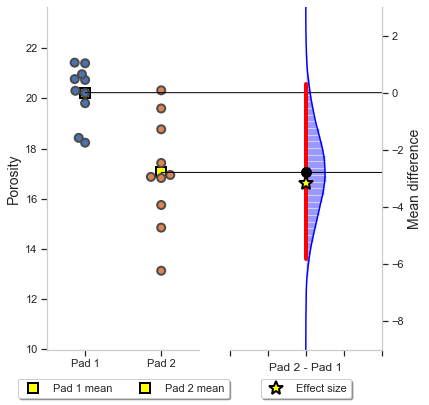

In [134]:
est_plot(pad1, pad2, 'Porosity', summary, same_pad=True)

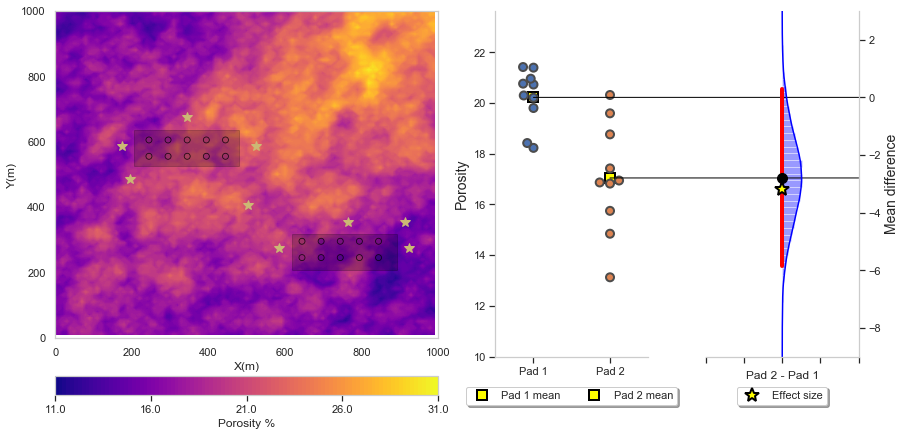

In [137]:
folder = 'Practical Workflow for Assessing Significance of Differences for Nonstationary Phenomenon'
directory = 'C:\\Users\\jjs4476\\Documents\\Papers\\' + folder + '/Fig6.tiff'

plotting(pad1, pad2, 'Porosity', summary, same_pad=True, simulation=combined_model,
        directory=directory, case=3)

The histogram of the null distribution looks like:

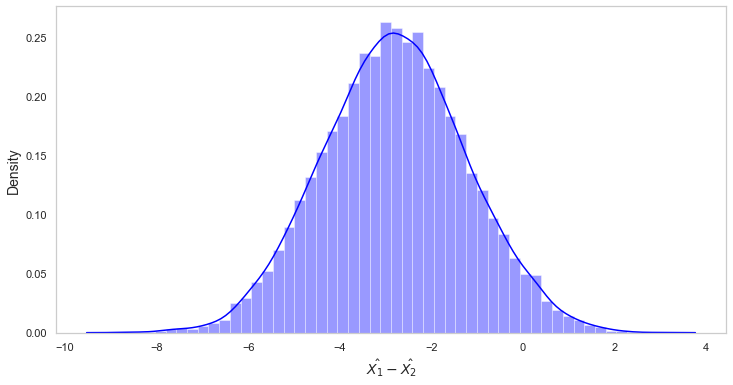

In [164]:
plt.figure(figsize=(12, 6))
sns.distplot(summary['Difference Means'], kde=True, color='blue')
plt.xlabel('$\hat{X_1} - \hat{X_2}$', fontsize=14)
plt.ylabel('Density', fontsize=14);

In [74]:
############################################################
## Critical values (empirical)
############################################################
per_up_10 = summary['Difference Means'].quantile(q=0.950); per_down_10 = summary['Difference Means'].quantile(q=0.050)
per_up_05 = summary['Difference Means'].quantile(q=0.975); per_down_05 = summary['Difference Means'].quantile(q=0.025)
per_up_01 = summary['Difference Means'].quantile(q=0.995); per_down_01 = summary['Difference Means'].quantile(q=0.005)

print('{0:5^s}'.format('CONFIDENCE INTERVALS'))
print('The 90% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_10, per_up_10))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))
print('The 99% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_01, per_up_01))

CONFIDENCE INTERVALS
The 90% CI: -5.35 < μ1-μ2 < -0.18
The 95% CI: -5.84 < μ1-μ2 < 0.30
The 99% CI: -6.77 < μ1-μ2 < 1.20


In [75]:
############################################################
## Insert observed difference
############################################################
observed_diff = -2 # pad1['Porosity'].mean() - pad2['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(summary['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=summary['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(summary['Difference Means'], other_diff)
denominator = length + 1

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(summary['Difference Means'] > observed_diff)
    smaller_than_left = sum(summary['Difference Means'] < other_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(summary['Difference Means'] > other_diff)
    smaller_than_left = sum(summary['Difference Means'] < observed_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: -2.00
Empirical p-value: 60.94%
Bayes factor bound: 1.22
There is at maximum a 54.93% chance the alternative hypothesis is true


## Further aplications

We will assign two well pads and gradually increase the influence of the trend using the following equation:

$trend = (trend - \mu_{trend}) * \text{constant} + \mu_{trend}$

$0 \leq \text{constant} \leq1$

The purpose is to weaken the trend, and the run the results again with the wrong trend to show false positives as far as believing it is unique and different. The resampling distribution comes from case 2.2, as well as the sample locations. Recall that when **constant=1** , the hypothesis should fail to reject the null hypothesis.

In [13]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 43                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 45                    # Porosity variogram ranges and azimuth
mean = 15.0; stdev = 1.5                                         # Porosity mean and standard deviation
cmap = plt.cm.inferno                                            # using the plasma color map

vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

In [14]:
############################################################
# Assign the well locations
############################################################
# Pad 1
ox = 65; oy = 70 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells

# Pad 2
ox2 = 65; oy2 = 2 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells

# Load back the data and update the effect size
summary = pd.read_pickle(path + "./case22.pkl")
summary['Difference Means'] = summary['N2 Mean'] - summary['N1 Mean']

The code below will take the porosity values for different geological models (stationary + weakened trend) 100 times, and compare the observed effect size $\mu_2 - \mu_1$ with the sampling distribution of the correct trend model.

In [15]:
start = 0.
stop  = 1.01
step  = 0.01 # self explanatory

# obtain the length of the DataFrame, i.e. number of rows
denominator = len(summary['Difference Means']) + 1

# create the DataFrame that will store all results
n_results = len(np.arange(start, stop, step))
results = pd.DataFrame(np.zeros((n_results, 6)), columns=['Constant', 'p value', 'BFB', 'Pr', 'Effect Size', 'Variance Model'])
results['Constant'] = np.arange(start, stop, step)

for index, constant_i in enumerate(np.arange(start, stop, step)):
    temp_trend = (trend - trend_mean) * constant_i + trend_mean
    temp_model = sim + temp_trend
    # Extract the porosity values of the well pads with the new model
    pad1 = extract_pad_sample(temp_model, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
    
    pad2 = extract_pad_sample(temp_model, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')
    
    ############################################################
    ## Insert observed difference
    ############################################################
    observed_diff = pad2['Porosity'].mean() - pad1['Porosity'].mean()
    results.iloc[index, 4] = observed_diff
    
    ############################################################
    ## Final computations
    ############################################################
    # compute the corresponding percentile of the value entered for the other tail (left or right)
    other_diff = 100 - scipy.stats.percentileofscore(a=summary['Difference Means'], score=observed_diff)
    # obtain the value corresponding to the above percentile (left or right)
    other_diff = np.percentile(summary['Difference Means'], other_diff)

    if other_diff < observed_diff: # observed difference is on the right
        larger_than_right = sum(summary['Difference Means'] > observed_diff)
        smaller_than_left = sum(summary['Difference Means'] < other_diff)
        results.iloc[index, 1] = (larger_than_right + smaller_than_left + 1 + 1) / denominator
    else:
        larger_than_right = sum(summary['Difference Means'] > other_diff)
        smaller_than_left = sum(summary['Difference Means'] < observed_diff)
        results.iloc[index, 1] = (larger_than_right + smaller_than_left + 1 + 1) / denominator
        
    results.iloc[index, 5] = np.var(temp_model)

results['BFB'] = (-1)/(np.e * results['p value'] * np.log(results['p value']))
results['Pr'] = results['BFB'] / (1 + results['BFB'])
results['Var Ratio'] = results['Variance Model'] / np.var(sim + trend)

In [23]:
results.tail()

,Constant,p value,BFB,Pr,Effect Size,Variance Model,Var Ratio
96,0.96,0.6842,1.416788,0.586228,-8.716465,10.272591,0.939176
97,0.97,0.7674,1.810725,0.644220,-8.807235,10.436428,0.954155
98,0.98,0.8456,2.594087,0.721765,-8.898004,10.601921,0.969286
99,0.99,0.9198,4.784217,0.827116,-8.988774,10.769068,0.984567
100,1.00,0.9970,122.810881,0.991923,-9.079544,10.937871,1.000000


In [25]:
len(results[results['BFB'] > 20]) / len(results)

0.7227722772277227

In [22]:
results[results['p value'] < 0.01].tail()

,Constant,p value,BFB,Pr,Effect Size,Variance Model,Var Ratio
70,0.70,0.0028,22.351561,0.957176,-6.356455,6.593731,0.602835
71,0.71,0.0032,20.012226,0.952409,-6.447224,6.714538,0.613880
72,0.72,0.0044,15.408522,0.939056,-6.537994,6.837000,0.625076
73,0.73,0.0062,11.672829,0.921091,-6.628763,6.961117,0.636423
74,0.74,0.0090,8.677471,0.896667,-6.719533,7.086889,0.647922


Let's visualize the main results:

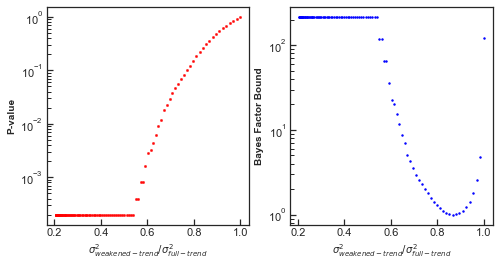

In [21]:
sns.set_style("ticks", {'xtick.direction': 'in', 'ytick.direction': 'in'})
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 4))

##################################################################
# Constant vs p value
##################################################################
ax1.semilogy(results['Var Ratio'], results['p value'], 's',
         markerfacecolor='red', markeredgecolor='red', markeredgewidth=1,
         markersize=1.5, label='Lorenz curve', alpha=0.9)

ax1.set_xlabel('$\sigma^2_{weakened-trend} / \sigma^2_{full-trend}$', fontsize=10, fontweight='bold')
ax1.set_ylabel('P-value', fontsize=10, fontweight='bold')
# ax1.set(xlim=(.5, .6), ylim=(0, 1))

##################################################################
# Constant vs BFB
##################################################################
ax2.semilogy(results['Var Ratio'], results['BFB'], 'o',
         markerfacecolor='blue', markeredgecolor='blue', markeredgewidth=1,
         markersize=1.5, label='Little Creek Field', alpha=0.9)

ax2.set_xlabel('$\sigma^2_{weakened-trend} / \sigma^2_{full-trend}$', fontsize=10, fontweight='bold')
ax2.set_ylabel('Bayes Factor Bound', fontsize=10, fontweight='bold')

##################################################################
# Save plot
##################################################################
folder = 'Practical Workflow for Assessing Significance of Differences for Nonstationary Phenomenon'
directory = 'C:\\Users\\jjs4476\\Documents\\Papers\\' + folder + '/Fig7.tiff'
fig.savefig(directory, dpi=700, format="tiff", bbox_inches='tight')

plt.show()

Generate the first simulation and plot it. Recall that it does not have a  trend.

<Figure size 720x576 with 0 Axes>

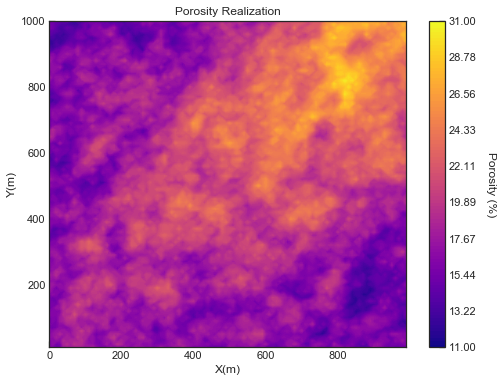

In [47]:
temp_tend = (trend - trend_mean) * 1 + trend_mean
temp_model = sim + temp_tend

plt.figure(figsize=(10, 8));
cmap = plt.cm.plasma
GSLIB.pixelplt(temp_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(temp_model)), np.ceil(np.max(temp_model)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_temp_modelulation');